#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install --upgrade tensorflow --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-text 2.17.0 requires tensorflow<2.18,>=2.17.0, but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os

DATASET_PATH = "/kaggle/input/fruits-classification/dataset"
print("Contents of 'dataset' Folder:", os.listdir(DATASET_PATH))


Contents of 'dataset' Folder: ['test', 'train']


In [6]:
#  IMAGE DATA PREPROCESSING (Reduce Image Size)
IMG_SIZE = (128, 128)    
BATCH_SIZE = 32  


#  Image Augmentation for Better Generalization
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,   # Increased from 20
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,      # Increased from 0.15
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  
)


In [7]:
# Load Training & Validation Data
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",  #  Point to "train" folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    interpolation='nearest'
)

Found 4281 images belonging to 7 classes.


In [8]:

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",  # Validation still from "train" (20% split)
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    interpolation='nearest'
)

#  Load Separate Test Data
test_generator = train_datagen.flow_from_directory(
    DATASET_PATH + "/test",  #  Point to "test" folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    interpolation='nearest'
)

#  Verify Classes
print("Class Indices:", train_generator.class_indices)


Found 1068 images belonging to 7 classes.
Found 1339 images belonging to 7 classes.
Class Indices: {'apple': 0, 'broccoli': 1, 'grape': 2, 'lemon': 3, 'mango': 4, 'orange': 5, 'strawberry': 6}


In [9]:
#  Get Number of Classes
num_classes = len(train_generator.class_indices)

#  LOAD PRETRAINED MOBILENETV2 MODEL (Optimized for GPU)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),  # Adjusted input size
    include_top=False,
    weights='imagenet'
)
# Freeze first few layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Fine-tune only the later layers
for layer in base_model.layers[100:]:
    layer.trainable = True


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Build Classifier Model

from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Optimizer with Gradient Clipping
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)



In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [12]:

#  TRAIN THE MODEL


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * (0.95 ** epoch)
)



# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 120s 643ms/step - accuracy: 0.3361 - loss: 6.3550 - precision: 0.3984 - recall: 0.2500 - val_accuracy: 0.5927 - val_loss: 5.3355 - val_precision: 0.6675 - val_recall: 0.5112 - learning_rate: 1.0000e-04
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.6408 - loss: 5.1306 - precision: 0.7111 - recall: 0.5788 - val_accuracy: 0.6489 - val_loss: 5.1221 - val_precision: 0.6886 - val_recall: 0.6273 - learning_rate: 9.5000e-05
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 37s 267ms/step - accuracy: 0.7098 - loss: 4.7162 - precision: 0.7596 - recall: 0.6557 - val_accuracy: 0.6096 - val_loss: 5.0971 - val_precision: 0.6410 - val_recall: 0.5852 - learning_rate: 9.0250e-05
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 36s 257ms/step - accuracy: 0.7426 - loss: 4.3847 - precision: 0.7999 - recall: 0.7053 - val_accuracy: 0.6957 - val_loss: 4.6125 - val_precision: 0.7184 - val_recall: 0.6760 - learning_rate: 8.5737e-05
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 34s 24

In [13]:
model.save("fruit_classifier_model.h5")


In [14]:
from tensorflow.keras.models import load_model

model = load_model("fruit_classifier_model.h5")


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [16]:
# Class labels (modify based on your dataset)
class_labels = list(train_generator.class_indices.keys())

In [17]:
class_labels

['apple', 'broccoli', 'grape', 'lemon', 'mango', 'orange', 'strawberry']

In [18]:

def predict_and_display(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))  # Resize to match training size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    fruit_name = class_labels[predicted_class]  # Get predicted label

    # Display image with prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {fruit_name}", fontsize=14, fontweight="bold", color="green")
    plt.show()

    print(f"Prediction: {fruit_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


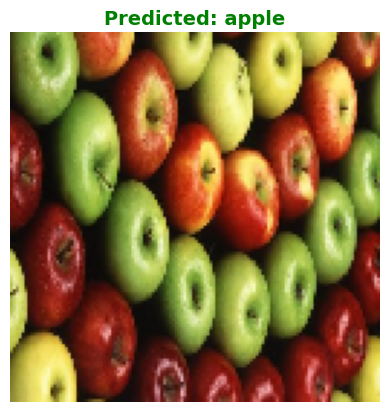

Prediction: apple


In [19]:
image_path = "/kaggle/input/fruits-classification/dataset/test/apple/apple_01.jpg"  
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


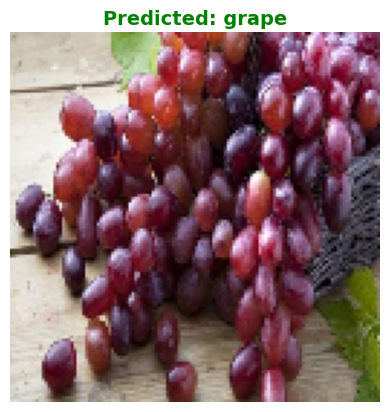

Prediction: grape


In [20]:
image_path = "/kaggle/input/fruits-classification/dataset/test/grape/grape_12.jpg"
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


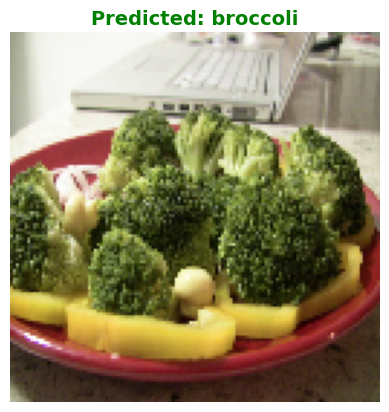

Prediction: broccoli


In [21]:
image_path = "/kaggle/input/fruits-classification/dataset/test/broccoli/broccoli_112.jpg"
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


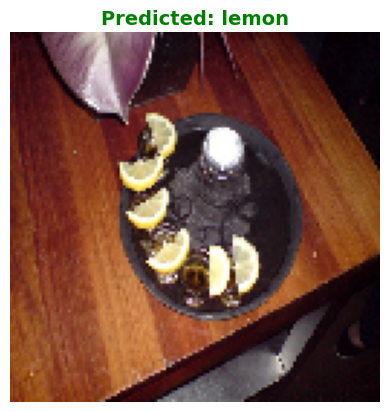

Prediction: lemon


In [22]:
image_path = "/kaggle/input/fruits-classification/dataset/test/lemon/lemon_103.jpg"
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


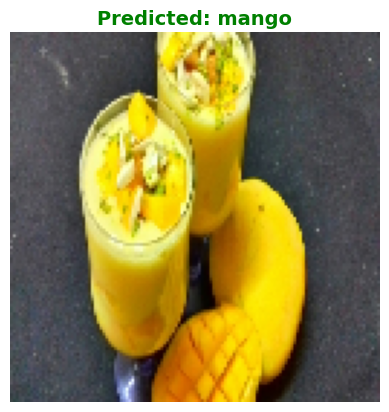

Prediction: mango


In [23]:
image_path = "/kaggle/input/fruits-classification/dataset/test/mango/mango_113.jpg"
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


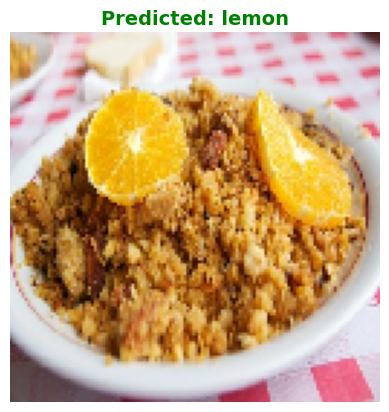

Prediction: lemon


In [24]:
image_path = "/kaggle/input/fruits-classification/dataset/test/orange/orange_153.jpg"
predict_and_display(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


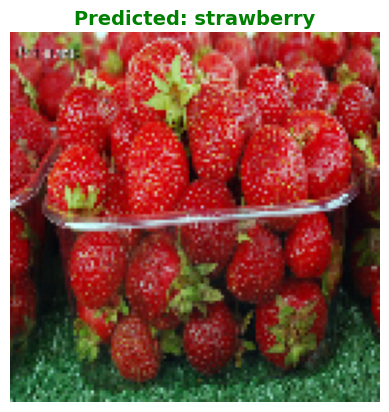

Prediction: strawberry


In [25]:
image_path = "/kaggle/input/fruits-classification/dataset/test/strawberry/strawberry_124.jpg"
predict_and_display(image_path)